In [1]:
import datetime as dt
import numpy as np
from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import regex as re
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows=500
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)
import scipy.stats as scs
from datetime import date
import datetime
from datetime import datetime
import datetime
# from fbprophet import Prophet
import os
import scipy.stats as stats
from pathlib import Path
import statsmodels.api as sm
print(datetime.datetime.now() )

2023-04-19 15:06:08.550713


In [2]:
time_one='10:30:00'
time_two='13:00:00'

abs_return_one=0.25
abs_return_two=0.25

In [3]:
# Define class here
class GPDataProcessor():
        
    # Path to where we store the data
#     data_folder_path = Path('C:/Users/15124/Desktop/Articles/data') 

    
    # Constructor, loads/cleans/merges data as needed
    def __init__(self):
        
        # Load price data
#         self.intradata = pd.read_csv(self.data_folder_path / 'intraday.csv')
        self.intradata = pd.read_csv('intraday.csv')

                
    def filter_date(self):
        # convert into date column
        self.intradata['Date']=pd.to_datetime(self.intradata['Date'])
        # split date into date and time columns for signal data
        self.intradata['date']=self.intradata['Date'].dt.date
        self.intradata['hour']=self.intradata['Date'].dt.time
        # sort
        self.intradata=self.intradata.sort_values(['date','hour'],ascending=[True,True])
        # filter out times we dont need and drop everything from the first day except for the closing price
        dfs=self.intradata.loc[(self.intradata['hour'].astype(str)==time_one)|(self.intradata['hour'].astype(str)==time_two)|(self.intradata['hour'].astype(str)=='15:30:00')]
        self.intradata.reset_index(inplace=True)
        
        
        # Find return
        dfs['nav']=dfs['Close'].pct_change()*100
        # True if returns are positive and false if returns are negative
        dfs['signal']=dfs['nav']>0
        # absolute returns
        dfs['abs_returns']=abs(dfs['nav'])
        return dfs

class GPTradingRule():
    
    # strategy-specifc columns for trades_df (variables we want to keep track of for subsequent analysis)
    # In this case, just gross profitability ratio 'gp'
#     strategy_specific_trades_df_columns = {'gp': pd.Series([], dtype='float')} 
#     value_weighted = True
    
    def __init__(self,df):
        self.df = df
    
    def trade(self,df):
        
        # the absolute returns are because it doesnt matter if it moves up or down but it does have to move 25 bps in one direction for us to buy and one direction for us to sell when it does in a different direction
        # we buy when it goes down
        buy=self.df[(self.df['abs_returns']>abs_return_one)&(self.df['hour'].astype(str)==time_one)&(self.df['nav']<0)]
        buy_lst=buy['date'].to_list()

        # sell when it goes up
        sell=self.df[(self.df['abs_returns']>abs_return_two)&(self.df['hour'].astype(str)==time_one)&(self.df['nav']>0)]
        sell_lst=sell['date'].to_list()

        
        
        # Filter dataframe to get buy and sell rows at 10:30 and 13:00 so we can find the returns of each of them
        buy_sort=self.df[(self.df['date'].isin(buy_lst))&((self.df['hour'].astype(str)==time_one)|((self.df['hour'].astype(str)==time_two)))]
        buy_sort['Returns']=buy_sort['Close'].pct_change()
        sell_sort=self.df[(self.df['date'].isin(sell_lst))&((self.df['hour'].astype(str)==time_one)|((self.df['hour'].astype(str)==time_two)))]
        sell_sort['Returns']=sell_sort['Close'].pct_change()

        # Now we have the returns at 13:00 for buys and sells
        buy_return=buy_sort[buy_sort['hour'].astype(str)==time_two]
        sell_return=sell_sort[sell_sort['hour'].astype(str)==time_two]
        
        return buy_return, sell_return

In [4]:
data_processor = GPDataProcessor()
# process the data
df=data_processor.filter_date()
print(len(df))

8028


In [5]:
# apply the trading rules
trading_rule=GPTradingRule(df)
buy_trade, sell_trade=trading_rule.trade(df)

In [6]:
print(len(buy_trade))
print(len(sell_trade))

696
887


In [7]:
# buy_trade

In [8]:
# find the cummulative returns for the trades where we buy (stock initially falls)
buy_trade['ret_cum_sum']=buy_trade['Returns'].cumsum()
b=buy_trade[['date','Returns','ret_cum_sum']]

# find the cummlative returns from the trades where we sell (stock initially rises)
sell_trade['Returns']=sell_trade['Returns']*-1    # this is negative because we sell when the stock goes up and make money when we short the stock
sell_trade['ret_cum_sum']=sell_trade['Returns'].cumsum()
s=sell_trade[['date','Returns','ret_cum_sum']]

In [9]:
# returns on all days form 10:30 to 1
# compute strategy return for all days
# create backtest statistician
# daily returns from stategy
# one column return 10:30 to 1 --long everyday
# multiply by 1 if buy, zero neutral, -1 
# get nav column then go by 

# beta adjustment-negative beta because we are shoring more often
# focus more on alpha-returns vs an index (S&P only trading half the days)

In [10]:
# All days but only 13:00
one=df[df['hour'].astype(str)==time_two]
# merge the buy and sell dataframes to the dataframe that contains all days and the time 13:00
two=one.merge(s, how='left',on='date').merge(b, how='left',on='date')

In [11]:
# convert the columns to a float, Fill NaN values as 0,  and then combine the returns for sell and buy into one column
two['Returns_x']=two['Returns_x'].astype(float).fillna(0)
two['Returns_y']=two['Returns_y'].astype(float).fillna(0)
two['Ret']=two['Returns_y']+two['Returns_x']

In [12]:
returns=two[['Close','date','hour','nav','Ret']]

In [13]:
# filter out the days where we do not buy or sell
returnz=returns[returns['Ret']!=0]
print(len(returnz))
ret_series=returnz['Ret']*100

1570


In [14]:
ret_series

1      -0.676069
4       0.036112
5      -0.613766
6      -0.143637
7      -0.078566
          ...   
2673   -0.870475
2674    0.210208
2675   -0.035613
2676   -0.189298
2678    0.798053
Name: Ret, Length: 1570, dtype: float64

In [54]:
backtest_stats = dict()
N=252 # I dont know where this came from but its the same number from the backtest


# means
backtest_stats['arith mean'] = ret_series.mean()
backtest_stats['arith mean (ann)'] = ret_series.mean()*N

# risks
backtest_stats['sigma'] = ret_series.std()
backtest_stats['sigma (ann)'] = ret_series.std()*(N**0.5)


# risk free rate from data given to us by Professor Travis
mkt_rf_df = pd.read_csv('mkt_rf_daily.csv')
mkt_rf_df.loc[:,'date'] = pd.to_datetime(mkt_rf_df.loc[:,'date'],format='%Y%m%d')
# filter the risk free rates based on our dates
mkt_rf_df = mkt_rf_df.loc[mkt_rf_df.loc[:,'date'].isin(returnz.loc[:,'date']),:]
# find returns of the risk free rate
mkt_series = mkt_rf_df.loc[:,'mkt_index'].pct_change().dropna().reset_index(drop=True)
rf_series = mkt_rf_df.loc[:,'rf_index'].pct_change().dropna().reset_index(drop=True)

In [55]:
# find the market return, convert the date column then merge into one dataframe
mkt_rf_df['mkt_return']=mkt_rf_df['mkt_index'].pct_change()*100
returnz['date']=pd.to_datetime(returnz['date'])
combined_market_sp=mkt_rf_df.merge(returnz,how='left',on='date')

In [56]:
# combined_market_sp

In [57]:
# Set up left- and right-hand sides for regressions
lhs = combined_market_sp['Ret']
rf_series= combined_market_sp['rf_index'].pct_change()*100
rf_series=rf_series[1:]
rhs = sm.add_constant( mkt_series - rf_series )

In [58]:
# NaN values were throwing off the regression so I dropped them and then reset the index for both the lhs and rhs (left hand side and right hand side)
l=lhs[1:-2]
l=l.reset_index()
l.drop(['index'], axis=1, inplace=True)

r=rhs[1:-2]
r.reset_index(inplace=True)

In [59]:
# Run the regression 
model = sm.OLS(l,r) 
results = model.fit()

In [60]:
# extract alpha and beta
backtest_stats['alpha'] = results.params['const']
backtest_stats['alpha SE'] = results.bse['const']
backtest_stats['alpha (ann)'] = results.params['const']*N
backtest_stats['alpha SE (ann)'] = results.bse['const']*N
backtest_stats['beta'] = results.params[0]
backtest_stats['betaSE'] = results.bse[0]        

# ratios        
backtest_stats['Sharpe ratio'] = backtest_stats['arith mean'] / backtest_stats['sigma']
backtest_stats['Sharpe ratio (ann)'] = backtest_stats['arith mean (ann)'] / backtest_stats['sigma (ann)']
backtest_stats['information ratio'] = backtest_stats['alpha'] / backtest_stats['sigma']
backtest_stats['information ratio (ann)'] = backtest_stats['alpha (ann)'] / backtest_stats['sigma (ann)']

In [61]:
backtest_stats

{'arith mean': -0.009080294698614636,
 'arith mean (ann)': -2.2882342640508884,
 'sigma': 0.4644082828654136,
 'sigma (ann)': 7.372252939562539,
 'alpha': -0.00024432987974455097,
 'alpha SE': 0.00023792144708560827,
 'alpha (ann)': -0.06157112969562684,
 'alpha SE (ann)': 0.05995620466557328,
 'beta': 0.01177751892999574,
 'betaSE': 0.0070915404264050375,
 'Sharpe ratio': -0.01955239609980454,
 'Sharpe ratio (ann)': -0.3103846656930723,
 'information ratio': -0.0005261100819240949,
 'information ratio (ann)': -0.008351738634089839}

In [ ]:
backtest_stats['geoetric mean'] = stats.gmean(1+ret_series)-1
backtest_stats['geometric mean (ann)'] = stats.gmean(1+ret_series)**N-1

In [84]:
r_series = ret_series + 1

In [73]:
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())

In [99]:
geo_mean = g_mean(r_series)-1
geo_mean_ann = geo_mean**N-1
print(geo_mean)
print(geo_mean_ann)

-0.06977900658704461
-1.0


In [23]:
# Make and output the cumulative NAV history plot    
def nav_plot(df, col):

    plt.style.use('default')  # set plot style to 'default' 

    # Standard set-up for a matplotlib plot
    fig = plt.figure() # this will automatically show the most updated version of the plot after you run the cell, so no need to have a "fig" line later again
    ax = fig.add_subplot(1,1,1)
    plotdates =df.loc[:,'date']
    ax.plot(plotdates, df.loc[:,col])

    # Customize the plot properties
    ax.set_xlabel('Date')
    ax.set_yscale('log')
    ax.set_xlim(plotdates.min(), plotdates.max())
    ax.xaxis.set_major_formatter( mdates.DateFormatter('%Y'))  # format the tick labels using years

In [24]:
fig, ax=plt.subplots(frameon=False, figsize=(13,6))

ax.set_xlabel('Date')
ax.plot(returnz['date'],returnz['Ret'], color='darkslategrey')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("S&P Trial Returns")
ax.grid()

plt.show()

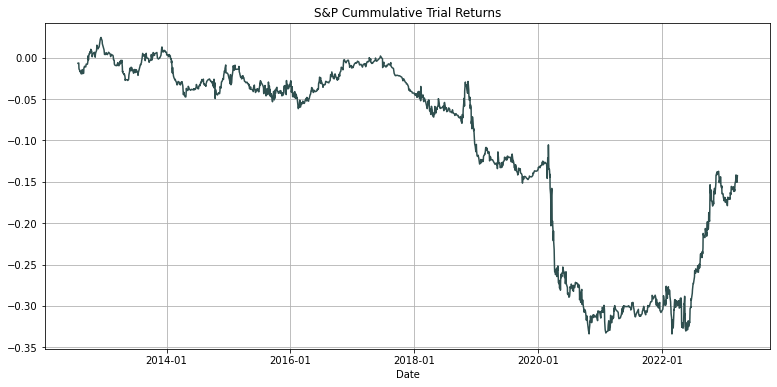

In [25]:
fig, ax=plt.subplots(frameon=False, figsize=(13,6))

ax.set_xlabel('Date')
ax.plot(returnz['date'],returnz['Ret'].cumsum(), color='darkslategrey')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("S&P Cummulative Trial Returns")
ax.grid()

plt.show()

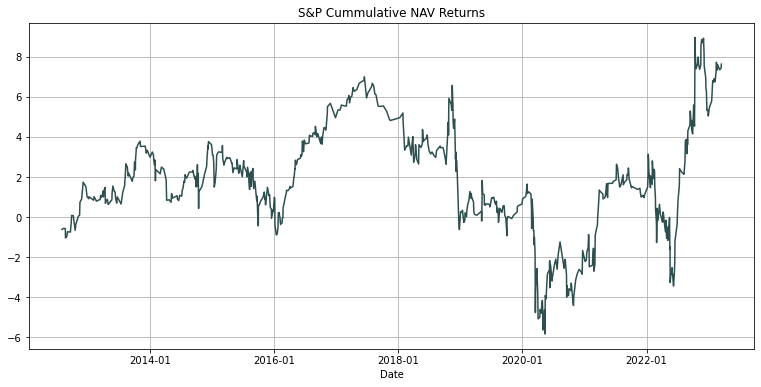

In [26]:
fig, ax=plt.subplots(frameon=False, figsize=(13,6))

ax.set_xlabel('Date')
ax.plot(returnz['date'],returnz['nav'].cumsum(), color='darkslategrey')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("S&P Cummulative NAV Returns")
ax.grid()

plt.show()

In [27]:
fig, ax=plt.subplots(frameon=False, figsize=(13,6))

ax.set_xlabel('Date')
ax.plot(returnz['date'],returnz['nav'], color='darkslategrey')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("S&P NAV Returns")
ax.grid()

plt.show()

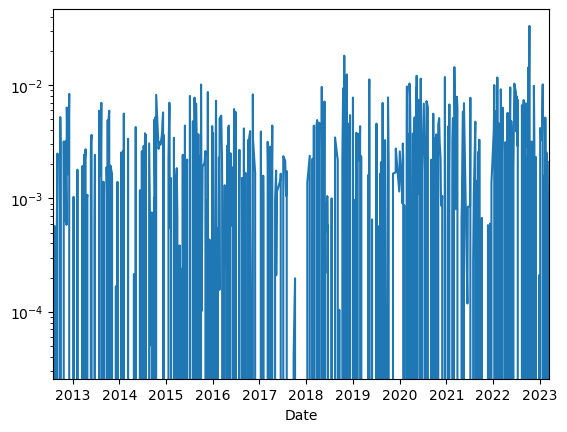

In [28]:
nav_plot(returnz,'Ret')

In [29]:
nav_plot(returnz,'nav')